### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat May 24 12:29:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

## Download dataset from Roboflow Universe

In [4]:


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9nvUDZZVlb3HAMJwVawA")
project = rf.workspace("fastnuces-uakqb").project("fyp-shoplift")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FYP-Shoplift-1 in yolov11:: 100%|██████████| 1674/1674 [00:00<00:00, 7560.65it/s]


In [5]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [6]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [7]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['normal', 'shoplifting']

roboflow:
  workspace: fastnuces-uakqb
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [8]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.144 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/FYP-Shoplift-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, 

train: Scanning /content/FYP-Shoplift-1/train/labels... 584 images, 2 backgrounds, 0 corrupt: 100%|██████████| 584/584 [00:00<00:00, 2476.14it/s]

train: New cache created: /content/FYP-Shoplift-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/FYP-Shoplift-1/valid/labels... 167 images, 0 backgrounds, 0 corrupt: 100%|██████████| 167/167 [00:00<00:00, 1045.05it/s]

val: New cache created: /content/FYP-Shoplift-1/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.73G      3.064      3.718      4.215         16        640: 100%|██████████| 37/37 [00:21<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        167        168    0.00183      0.578    0.00922    0.00465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.81G      3.007      3.522      4.008         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        167        168    0.00182      0.578     0.0444    0.00867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.66G      2.736      3.215      3.596         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all        167        168      0.616       0.25      0.147      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.81G      2.511      2.962      3.222         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all        167        168      0.565      0.132     0.0755     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.84G      2.327      2.736      2.964         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        167        168      0.332       0.17      0.135     0.0544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.83G       2.25      2.456       2.85         29        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all        167        168      0.318      0.499      0.313      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.82G      2.193       2.33      2.741         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.423      0.411      0.276      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.81G      2.083      2.137      2.605         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        167        168      0.267      0.446      0.269       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.84G      1.985      2.119      2.566         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


                   all        167        168      0.352      0.555      0.329        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.83G      1.893      2.029      2.485         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all        167        168      0.497      0.573      0.432      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.83G      1.775      1.923      2.388         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.439      0.442      0.428      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.81G      1.673      1.858      2.289         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.525      0.562      0.439      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.84G      1.554      1.729      2.198         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all        167        168      0.649      0.587      0.521      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.83G      1.505       1.64      2.128         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

                   all        167        168      0.579      0.695      0.584      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.82G      1.332      1.508       2.01         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.672      0.646      0.638      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.81G      1.278      1.504      1.925         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.448      0.712      0.575      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.84G       1.17      1.432       1.85         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        167        168      0.625      0.592      0.613       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.82G       1.09      1.337      1.757         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168       0.63      0.649      0.584      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.83G      1.077      1.346      1.727         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.744       0.69      0.699        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.81G      1.022      1.253      1.693         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.739      0.627      0.637      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.84G     0.9437      1.202      1.611         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        167        168      0.724      0.745      0.696      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.83G     0.9414      1.211      1.603         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        167        168      0.738      0.699      0.695      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.82G     0.9251      1.163      1.567         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168       0.75      0.635      0.659      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.81G     0.8641      1.122      1.521         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.841      0.694      0.741      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.84G     0.8719      1.147      1.541         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        167        168       0.83      0.693      0.757      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.66G      0.848      1.094      1.502         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168      0.741      0.738      0.726      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.66G     0.8371      1.098       1.49         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        167        168      0.753      0.692      0.711      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.81G      0.758      1.006      1.421         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        167        168      0.685      0.763      0.754      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.66G     0.7638     0.9855      1.421         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        167        168      0.769      0.753      0.762       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.65G     0.7252     0.9713      1.395         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all        167        168       0.78      0.734      0.716       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.82G     0.7376     0.9851      1.384         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168      0.775      0.748      0.757      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.81G     0.7098     0.9336       1.37         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.797      0.751      0.767      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.66G     0.6796     0.9522      1.357         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        167        168      0.729      0.789      0.783       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.83G     0.6714     0.9452      1.352         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.683       0.76      0.743      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.82G      0.649     0.9389      1.323         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

                   all        167        168      0.805      0.736      0.745      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       6.8G     0.6806     0.9216      1.362         16        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        167        168      0.765      0.795      0.768      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.66G     0.6463     0.9026      1.325         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


                   all        167        168      0.676      0.831      0.775      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.65G     0.6105     0.8532      1.296         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]

                   all        167        168      0.756      0.745      0.775      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.82G     0.6084     0.8542       1.28         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

                   all        167        168      0.679      0.791      0.776       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       6.8G     0.6121     0.8516      1.282         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        167        168      0.828      0.733      0.825      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.66G      0.573     0.8043      1.256         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        167        168       0.81      0.751      0.814      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.65G     0.5669     0.8189      1.266         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168       0.83      0.754      0.808      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.82G     0.5638     0.8018      1.242         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.735      0.836      0.799      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.81G     0.5615     0.7993      1.259         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.749       0.76      0.808      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.66G     0.5465     0.7997      1.241         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        167        168      0.798      0.785      0.819        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.83G     0.5517     0.7901      1.232         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all        167        168       0.78      0.765       0.84      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.65G     0.5258     0.7499      1.219         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.707      0.821      0.832      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.81G     0.5361     0.7669      1.233         27        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168       0.81      0.775      0.851      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.66G      0.528     0.7664      1.215         28        640: 100%|██████████| 37/37 [00:19<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all        167        168      0.693      0.821      0.814      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.65G     0.4889     0.7329      1.197         27        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.764      0.806      0.841      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.82G      0.518     0.7687      1.209         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.772      0.776      0.844      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       6.8G     0.4981     0.7393      1.184         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168      0.877      0.791      0.849      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.66G      0.484      0.721      1.173         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        167        168      0.762      0.842       0.87      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.65G     0.5059     0.7299      1.195         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.854      0.771      0.866       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.82G     0.4769     0.6838      1.171         15        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.724      0.859      0.867      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       6.8G     0.4819     0.7147      1.166         16        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

                   all        167        168      0.786      0.819      0.858      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.66G     0.4683      0.696      1.168         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        167        168      0.757      0.881      0.893      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.67G     0.4382     0.6662      1.135         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.792      0.881      0.907      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.82G      0.466      0.697      1.165         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.837      0.827      0.897      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.81G     0.4466     0.6743       1.13         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        167        168      0.872       0.82      0.877      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.66G     0.4414       0.67      1.143         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        167        168      0.767      0.878      0.887      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.65G     0.4464     0.6557      1.142         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.831      0.881       0.91      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.82G     0.4431     0.6764      1.146         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

                   all        167        168      0.813      0.861      0.886      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       6.8G     0.4598     0.6666      1.151         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        167        168      0.715      0.912      0.914      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.66G     0.4143     0.6148      1.118         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        167        168      0.885      0.794      0.907      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.65G     0.4318     0.6675      1.137         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.865      0.812       0.89      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.82G     0.4212     0.6287      1.133         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.737      0.934      0.891       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       6.8G     0.4141     0.5962      1.117         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.839      0.848      0.916      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.66G     0.4217     0.6342      1.123         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all        167        168      0.796      0.907      0.918      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.65G     0.4162     0.6141      1.119         16        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.797      0.897      0.913      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.82G     0.4418     0.6323      1.135         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.779      0.881      0.921      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       6.8G     0.4182     0.6239      1.112         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.901      0.804      0.919      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.66G     0.4122     0.6039      1.115         15        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all        167        168      0.812      0.899      0.918        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.83G     0.4189      0.609       1.11         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        167        168      0.851      0.859      0.918      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.82G     0.4057     0.6107      1.114         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.846      0.859      0.924      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.8G     0.4328     0.6209      1.124         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        167        168      0.809      0.906      0.927      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.66G     0.3831      0.565      1.102         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        167        168      0.809      0.924      0.932      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.83G     0.3713     0.5806      1.084         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.833      0.863      0.922      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.65G     0.3744     0.5762       1.09         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.853      0.896      0.929      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       6.8G     0.3838     0.5703      1.103         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.859      0.912      0.939      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.66G     0.3753     0.5719      1.097         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        167        168      0.812      0.887      0.931      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.65G     0.3827     0.5775      1.091         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.817      0.923      0.933      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.82G     0.3728     0.5623      1.094         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.819       0.93      0.935      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       6.8G     0.3594      0.552      1.083         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168      0.822      0.931      0.943      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.66G     0.3824     0.5708      1.102         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        167        168       0.91      0.912      0.947      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.65G     0.3904     0.5979      1.105         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.831      0.919      0.949      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.82G     0.3598     0.5644      1.083         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.823      0.914      0.943      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       6.8G     0.3894     0.5626      1.102         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.882      0.873       0.93      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.66G     0.3882     0.5545      1.096         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        167        168      0.867      0.908      0.948      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.83G     0.3481     0.5468      1.074         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

                   all        167        168      0.851      0.912      0.946       0.83


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.83G     0.4166     0.6124      1.136          8        640: 100%|██████████| 37/37 [00:21<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.792      0.942      0.946      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.81G     0.3707     0.4804      1.109          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.878      0.868      0.934      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.66G     0.3533     0.4326      1.102          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        167        168      0.884      0.912       0.95       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.65G       0.35     0.4312      1.084          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.914      0.879       0.95      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.82G     0.3388     0.4208      1.073          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

                   all        167        168      0.877      0.894      0.945      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.81G     0.3273     0.4132      1.081          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.865      0.915      0.951      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.66G     0.3282     0.3968      1.073          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        167        168       0.94      0.885      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.83G     0.3253     0.4093      1.072          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.904      0.894      0.955      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.82G     0.3168     0.3922      1.069          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.884      0.907      0.952      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.81G      0.327      0.391      1.071          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all        167        168      0.958       0.85      0.952      0.838



100 epochs completed in 0.621 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 18.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


                   all        167        168       0.94      0.886      0.955      0.841
                normal        101        102      0.898      0.971       0.97      0.967
           shoplifting         66         66      0.981      0.801       0.94      0.714
Speed: 0.2ms preprocess, 6.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train2


## Evaluate fine-tuned YOLOv12 model

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train2/

args.yaml					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch2.jpg
confusion_matrix.png				    train_batch3330.jpg
events.out.tfevents.1748089830.faaad4e28744.3492.0  train_batch3331.jpg
F1_curve.png					    train_batch3332.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


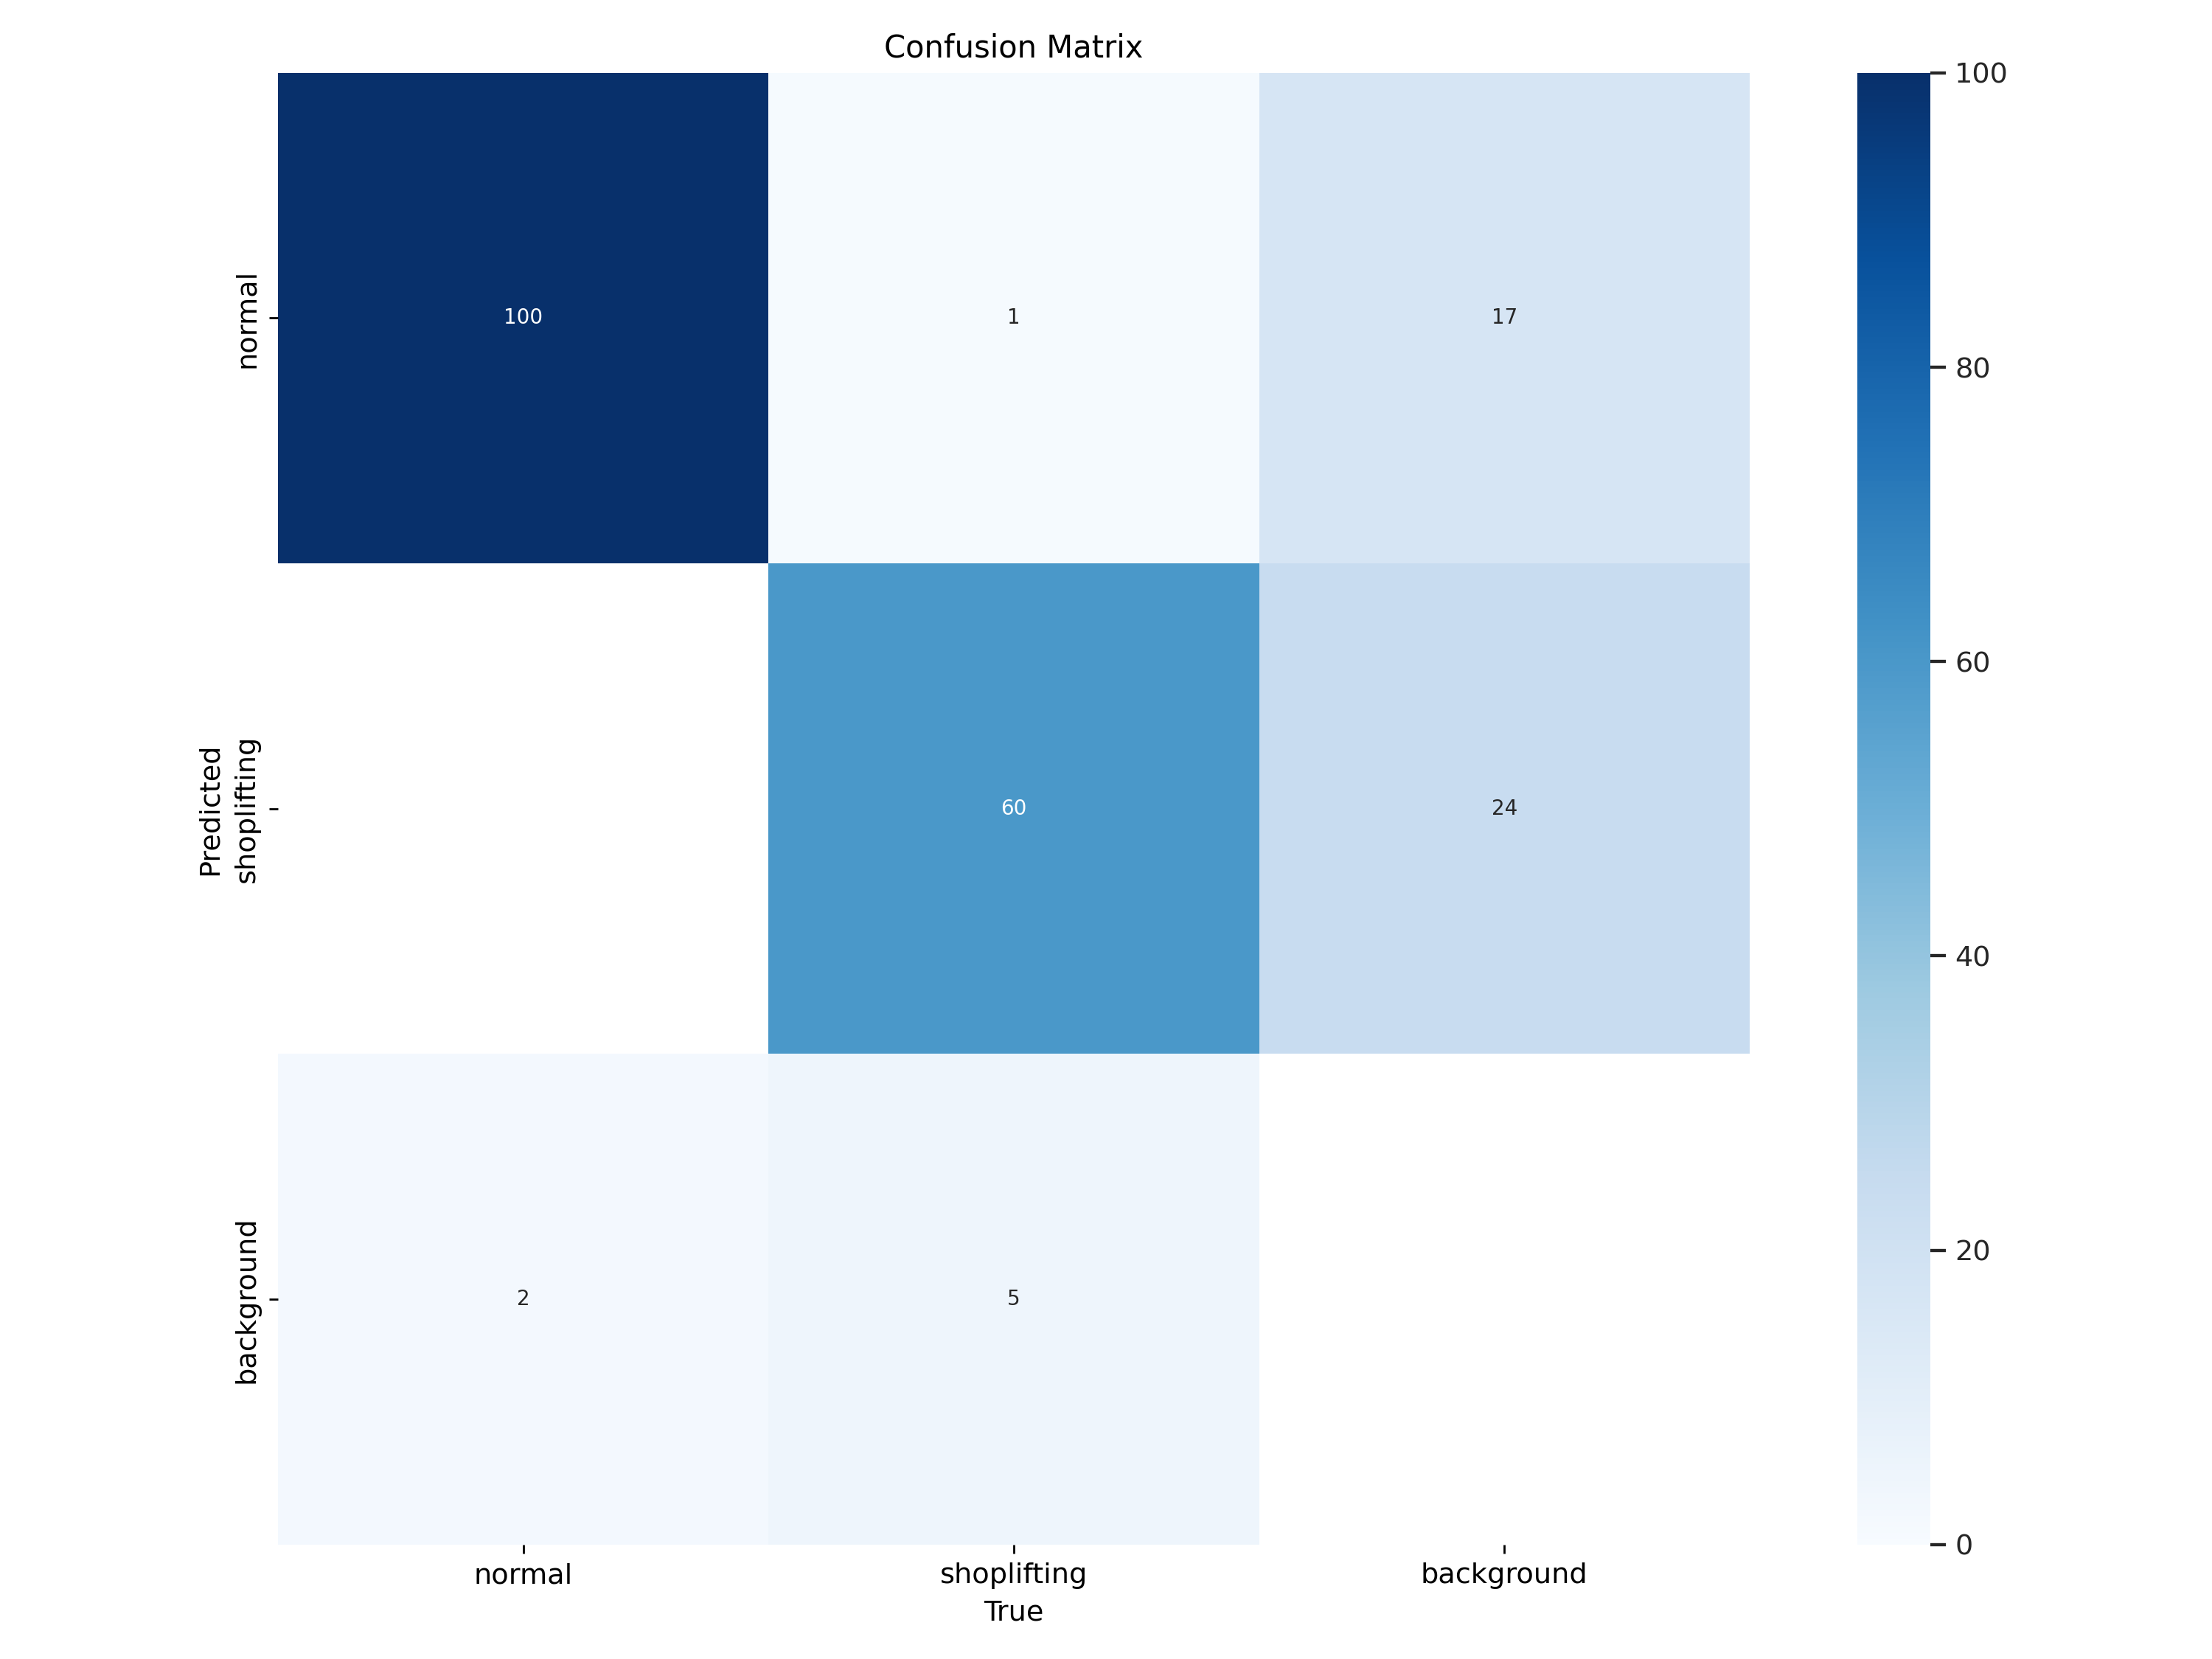

In [12]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=1000)

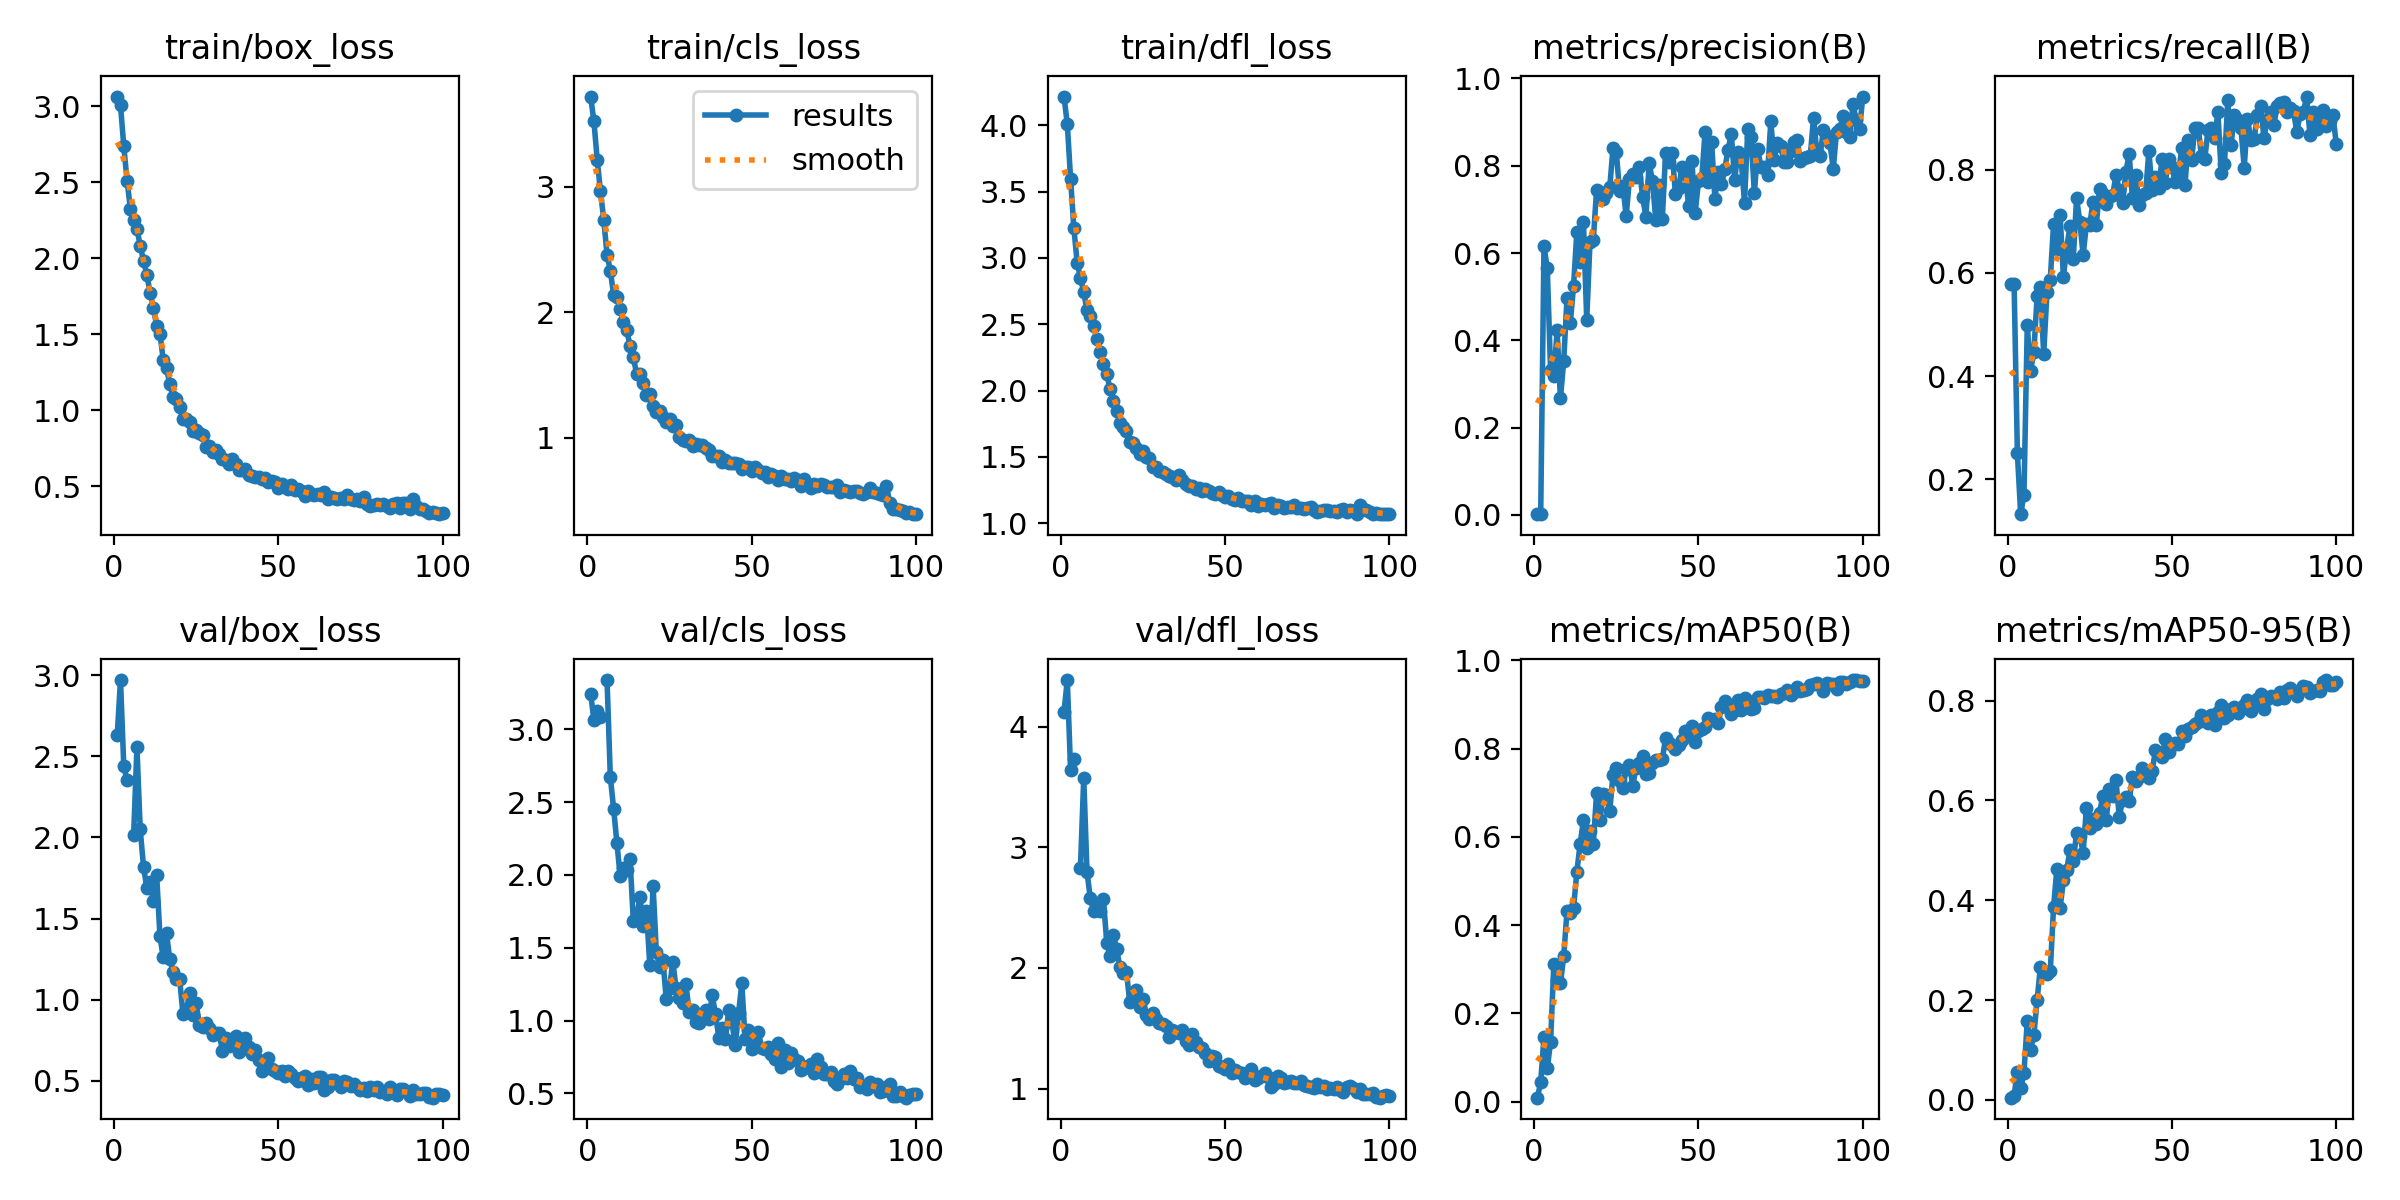

In [13]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000)

In [14]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['normal', 'shoplifting']

In [15]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [16]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.8252965536544743
mAP 50 0.9456499832435675
mAP 75 0.8859812617368841


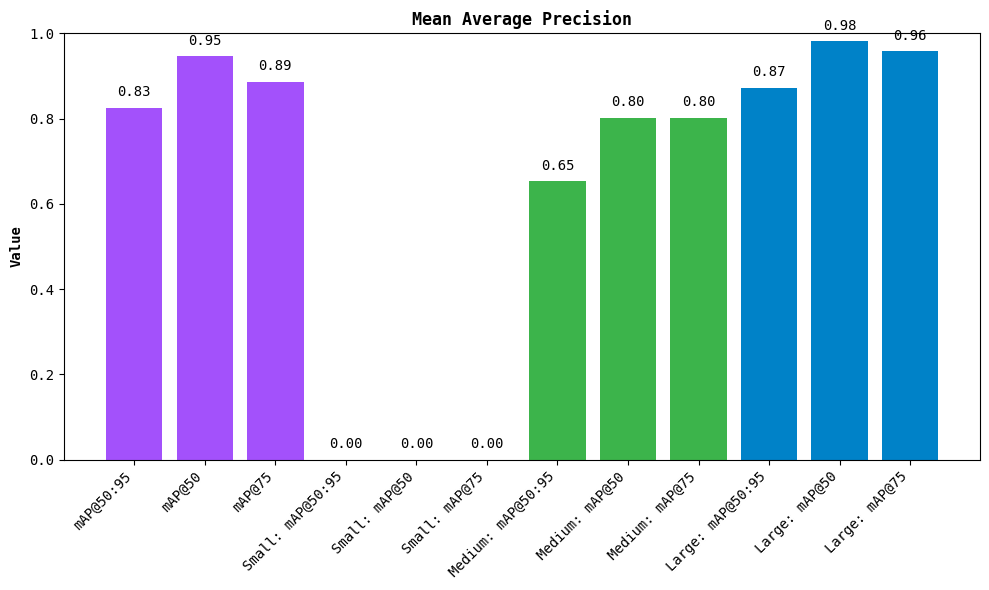

In [17]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [18]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

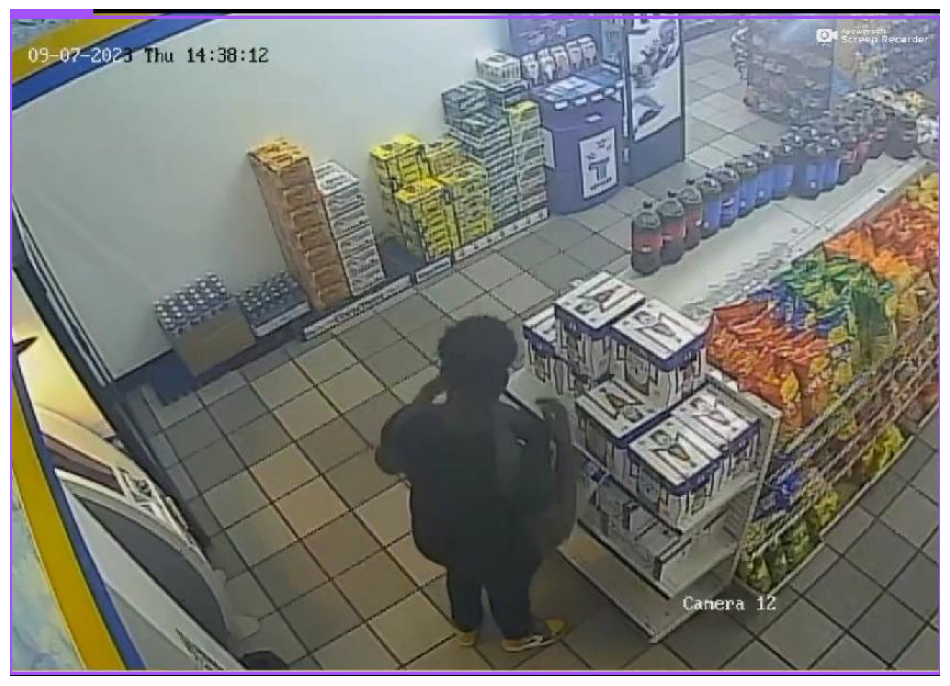

In [19]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)